
===== PERFORMANCE COMPARISON =====
                             Final    Profit  Sharpe  MaxDD  Trades
File        Strategy                                               
03feb-18feb Buy&Hold    1031855.25  31855.25    0.01  -0.02       1
            Combined     999608.75   -391.25   -0.00  -0.00     393
            MACD         992032.00  -7968.00   -0.01  -0.01     952
            RSI          998932.25  -1067.75   -0.00  -0.01     731
            Stochastic   995367.50  -4632.50   -0.01  -0.01     553
31mar-15apr Buy&Hold     975614.00 -24386.00   -0.00  -0.16       1
            Combined    1004937.25   4937.25    0.00  -0.02     369
            MACD        1002442.50   2442.50    0.00  -0.03     841
            RSI          987211.75 -12788.25   -0.00  -0.03     710
            Stochastic  1010147.00  10147.00    0.00  -0.02     636



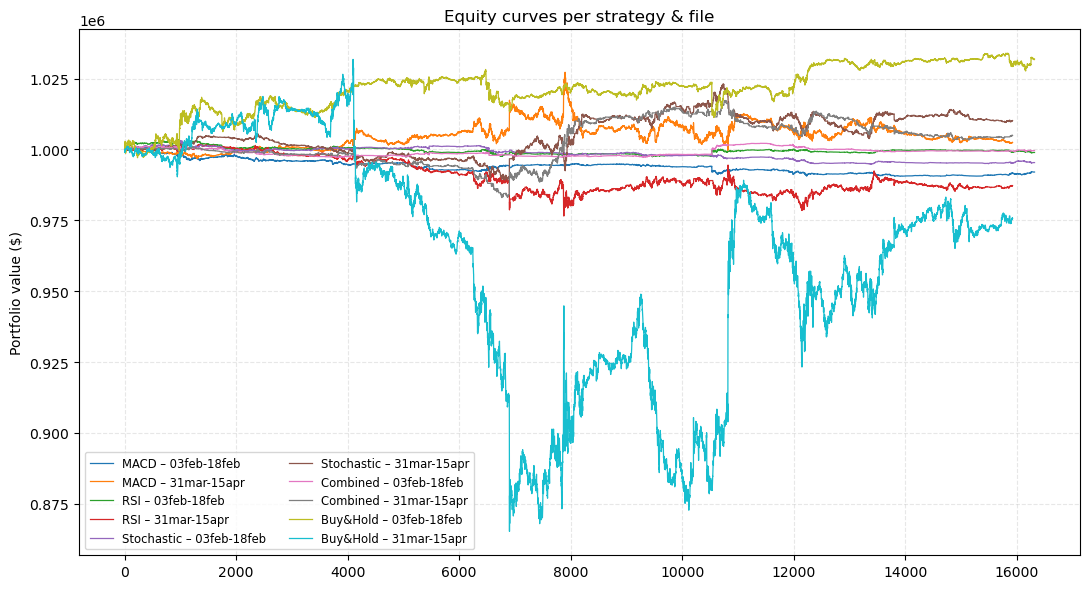

In [18]:
# ── intraday_compare.py ─────────────────────────────────────────────
"""
Analyse **each** 1-minute ES file separately, then compare strategy
performance side-by-side.

Files examined
--------------
• 03feb-18feb.csv   (03 Feb → 18 Feb 2025)
• 31mar-15apr.csv   (31 Mar → 15 Apr 2025)

Strategies
----------
MACD · RSI · Stochastic · Combined (MACD+RSI) · Buy&Hold
"""

from __future__ import annotations
import datetime as dt, re
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# ╭────────────────────╮
# │ 1. Data ingestion  │
# ╰────────────────────╯
_DATE = re.compile(r"(\d{2}[A-Z]{3}\d{4})_")        # e.g. 03FEB2025_

def parse_intraday(path: str | Path) -> pd.DataFrame:
    rows, cur_date = [], None
    path = Path(path)
    with path.open(encoding="utf-8") as fh:
        for raw in fh:
            line = raw.strip()
            if not line:
                continue
            if (m := _DATE.match(line)):                       # date row
                cur_date = dt.datetime.strptime(m[1], "%d%b%Y").date()
                continue
            if line.startswith(("Time Interval", "Summary")) or cur_date is None:
                continue                                       # headers / summaries
            if "-" in line.split(";", 1)[0]:                   # real data row
                cols = line.split(";")[:8]
                h, m = map(int, cols[0].split("-", 1)[0].split(":"))
                ts = dt.datetime.combine(cur_date, dt.time(h, m))
                nums = [float(n.replace(",", ".")) if n else np.nan for n in cols[1:8]]
                rows.append([ts] + nums)

    if not rows:
        raise ValueError(f"Nothing parsed from {path}")
    df = pd.DataFrame(rows, columns=[
        "timestamp", "close", "net", "open", "high", "low", "ticks", "volume"
    ]).set_index("timestamp")
    return df[["open", "high", "low", "close", "volume"]]


# ╭────────────────────╮
# │ 2. Indicators      │
# ╰────────────────────╯
def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ATR
    df["H-L"]   = df.high - df.low
    df["H-PC"]  = (df.high - df.close.shift()).abs()
    df["L-PC"]  = (df.low  - df.close.shift()).abs()
    df["TR"]    = df[["H-L", "H-PC", "L-PC"]].max(axis=1)
    df["ATR"]   = df.TR.rolling(14).mean()

    # MACD
    s, l, sig = 3, 15, 5
    df["MACD"]        = df.close.ewm(span=s, adjust=False).mean() - df.close.ewm(span=l, adjust=False).mean()
    df["MACD_signal"] = df.MACD.ewm(span=sig, adjust=False).mean()
    df["Signal_MACD"] = np.where(df.MACD > df.MACD_signal, 1, -1)

    # RSI
    delta, n = df.close.diff(), 14
    gain, loss = delta.clip(lower=0), -delta.clip(upper=0)
    rs = gain.rolling(n).mean() / loss.rolling(n).mean()
    df["RSI"]        = 100 - 100 / (1 + rs)
    df["Signal_RSI"] = np.select([df.RSI < 30, df.RSI > 70], [1, -1], 0)

    # Stochastic
    look = 14
    ll, hh = df.low.rolling(look).min(), df.high.rolling(look).max()
    df["%K"] = (df.close - ll) / (hh - ll) * 100
    df["%D"] = df["%K"].rolling(3).mean()
    prev_k, prev_d = df["%K"].shift(), df["%D"].shift()
    buy  = (prev_k < prev_d) & (df["%K"] > df["%D"]) & (df["%K"] < 20)
    sell = (prev_k > prev_d) & (df["%K"] < df["%D"]) & (df["%K"] > 80)
    df["Signal_Stoch"] = 0
    df.loc[buy,  "Signal_Stoch"] = 1
    df.loc[sell, "Signal_Stoch"] = -1

    # Combined MACD+RSI
    df["Signal_Comb"] = 0
    df.loc[(df.Signal_MACD == 1) & (df.Signal_RSI == 1), "Signal_Comb"]  = 1
    df.loc[(df.Signal_MACD == -1) & (df.Signal_RSI == -1), "Signal_Comb"] = -1
    return df


# ╭────────────────────╮
# │ 3. Back-test       │
# ╰────────────────────╯
def _qty(price: float, cash: float, pct: float = .2, cap: int = 500) -> int:
    return min(cap, int((cash * pct) / price))

def _backtest(df: pd.DataFrame, sig: str, cash0: float = 1_000_000):
    cash, pos = cash0, 0
    fee, slm, tpm = 0., 1.5, 3.0
    entry = sl = tp = None
    port, logs = [], []

    for price, s, atr in zip(df.close, df[sig], df.ATR):
        # exit
        if pos > 0 and (price >= tp or price <= sl):
            pnl = (price - entry) * pos - fee
            cash += pos * price - fee; pos = 0
            logs.append(f"EXIT LONG pnl {pnl:.2f}")
        elif pos < 0 and (price <= tp or price >= sl):
            pnl = (entry - price) * -pos - fee
            cash -= price * -pos + fee; pos = 0
            logs.append(f"EXIT SHORT pnl {pnl:.2f}")

        # entry
        if pos == 0 and s and not np.isnan(atr):
            qty = _qty(price, cash)
            if qty:
                if s == 1:
                    cash -= qty * price + fee; pos = qty
                    entry, sl, tp = price, price - slm * atr, price + tpm * atr
                    logs.append(f"BUY  {qty}@{price:.2f}")
                else:
                    cash += qty * price - fee; pos = -qty
                    entry, sl, tp = price, price + slm * atr, price - tpm * atr
                    logs.append(f"SHORT {qty}@{price:.2f}")
        port.append(cash if pos == 0 else cash + pos * price)
    return port, logs

def _hold(df: pd.DataFrame, cash0: float = 1_000_000):
    p0 = df.close.iloc[0]
    qty = int(cash0 / p0); cash = cash0 - qty * p0
    port = cash + qty * df.close
    return port.tolist(), [f"BUY&HOLD {qty}@{p0:.2f}"]

def _mdd(arr):  # max draw-down
    arr = np.array(arr); roll = np.maximum.accumulate(arr)
    return float(((arr - roll) / roll).min())

def _sharpe(arr):
    r = pd.Series(arr).pct_change().dropna()
    return float(r.mean() / r.std()) if r.std() else np.nan


# ╭────────────────────╮
# │ 4. Comparison loop │
# ╰────────────────────╯
_DATA = {
    "03feb-18feb": Path("/Users/oscarolsen/Desktop/Algorithmic Trading/Algorithmic-Trading/alist/03feb-18feb.csv"),
    "31mar-15apr": Path("/Users/oscarolsen/Desktop/Algorithmic Trading/Algorithmic-Trading/alist/31mar-15apr.csv"),
}

_STRATS: Dict[str, str | None] = {
    "MACD":      "Signal_MACD",
    "RSI":       "Signal_RSI",
    "Stochastic":"Signal_Stoch",
    "Combined":  "Signal_Comb",
    "Buy&Hold":  None,
}

def run_comparison() -> pd.DataFrame:
    out_rows, plots = [], {}
    for name, path in _DATA.items():
        raw   = parse_intraday(path)
        df    = add_indicators(raw)

        for strat, sig in _STRATS.items():
            if strat == "Buy&Hold":
                port, log = _hold(df)
            else:
                port, log = _backtest(df, sig)
            out_rows.append(dict(
                File=name, Strategy=strat,
                Final=port[-1], Profit=port[-1]-1_000_000,
                Sharpe=_sharpe(port), MaxDD=_mdd(port),
                Trades=len([l for l in log if l.startswith(("BUY", "SHORT"))]),
            ))
            plots.setdefault(strat, {}).update({name: port})

    # ── pretty table
    df_res = pd.DataFrame(out_rows).set_index(["File","Strategy"])
    df_res = df_res.sort_index(level=0)
    print("\n===== PERFORMANCE COMPARISON =====")
    print(df_res.round(2).to_string())
    print()

    # ── overlay equity curves
    fig, ax = plt.subplots(figsize=(11,6))
    for strat, d in plots.items():
        for file, port in d.items():
            lbl = f"{strat} – {file}"
            ax.plot(port, label=lbl, linewidth=.9)
    ax.set_title("Equity curves per strategy & file")
    ax.set_ylabel("Portfolio value ($)")
    ax.legend(ncol=2, fontsize="small")
    ax.grid(alpha=.3, linestyle="--")
    plt.tight_layout()
    plt.show()

    return df_res

# expose global results when imported
RESULTS_DF = run_comparison() if __name__ == "__main__" else None


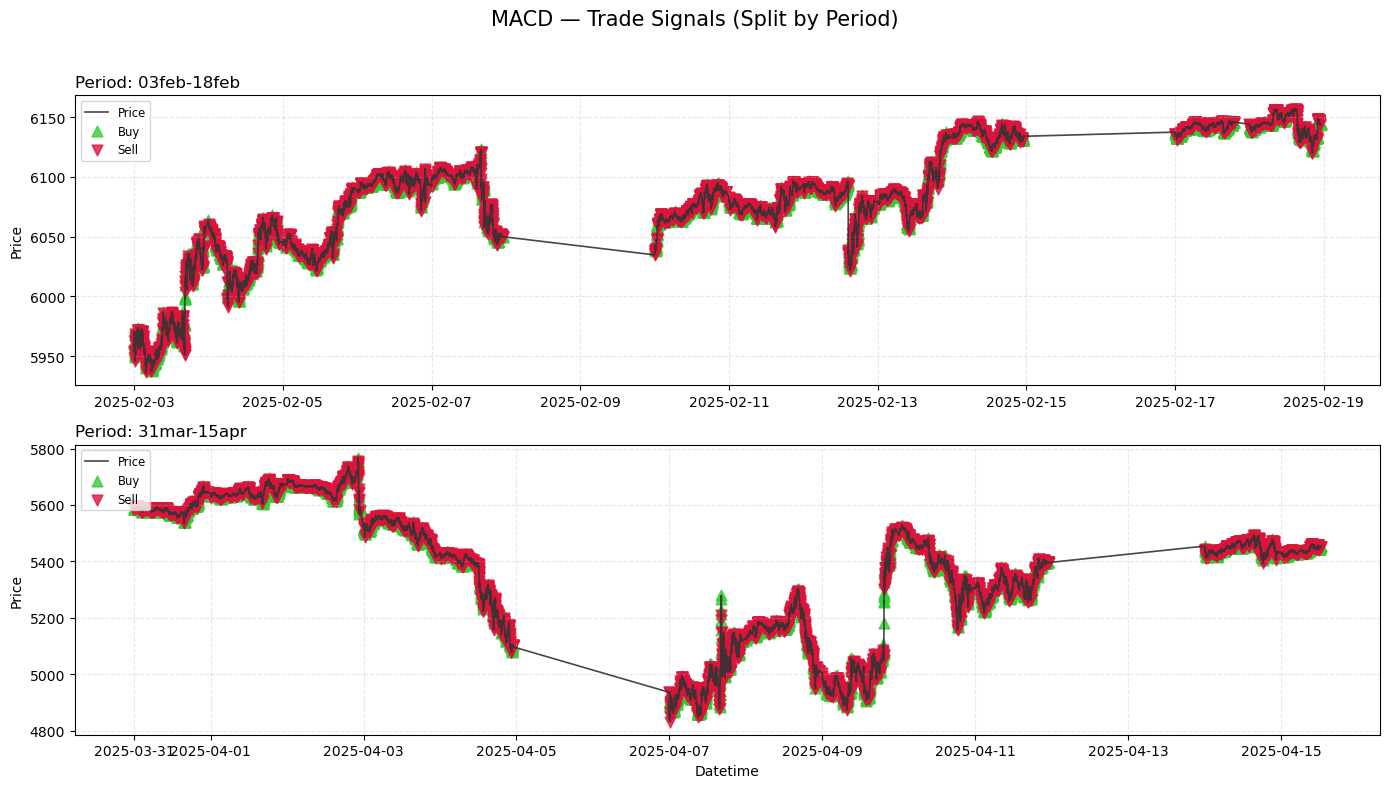

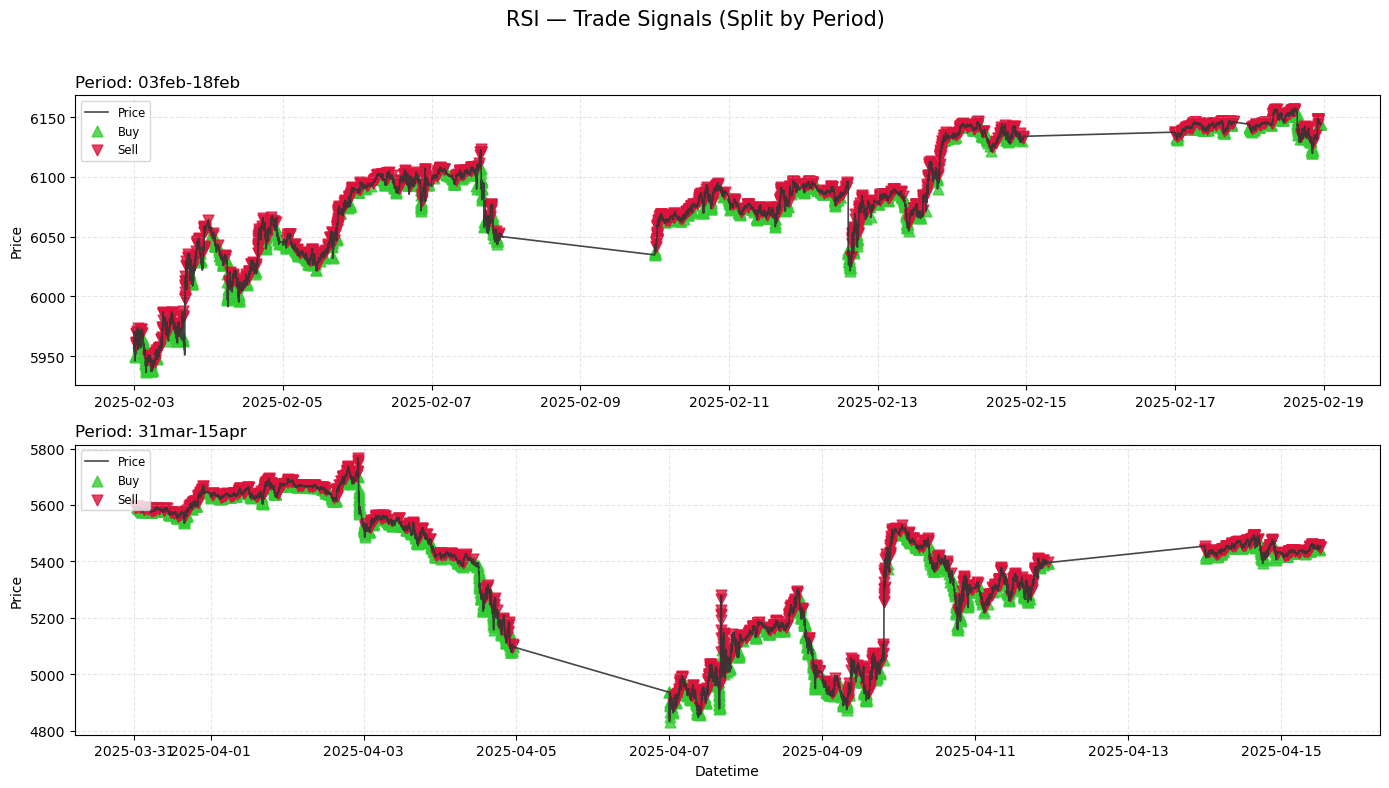

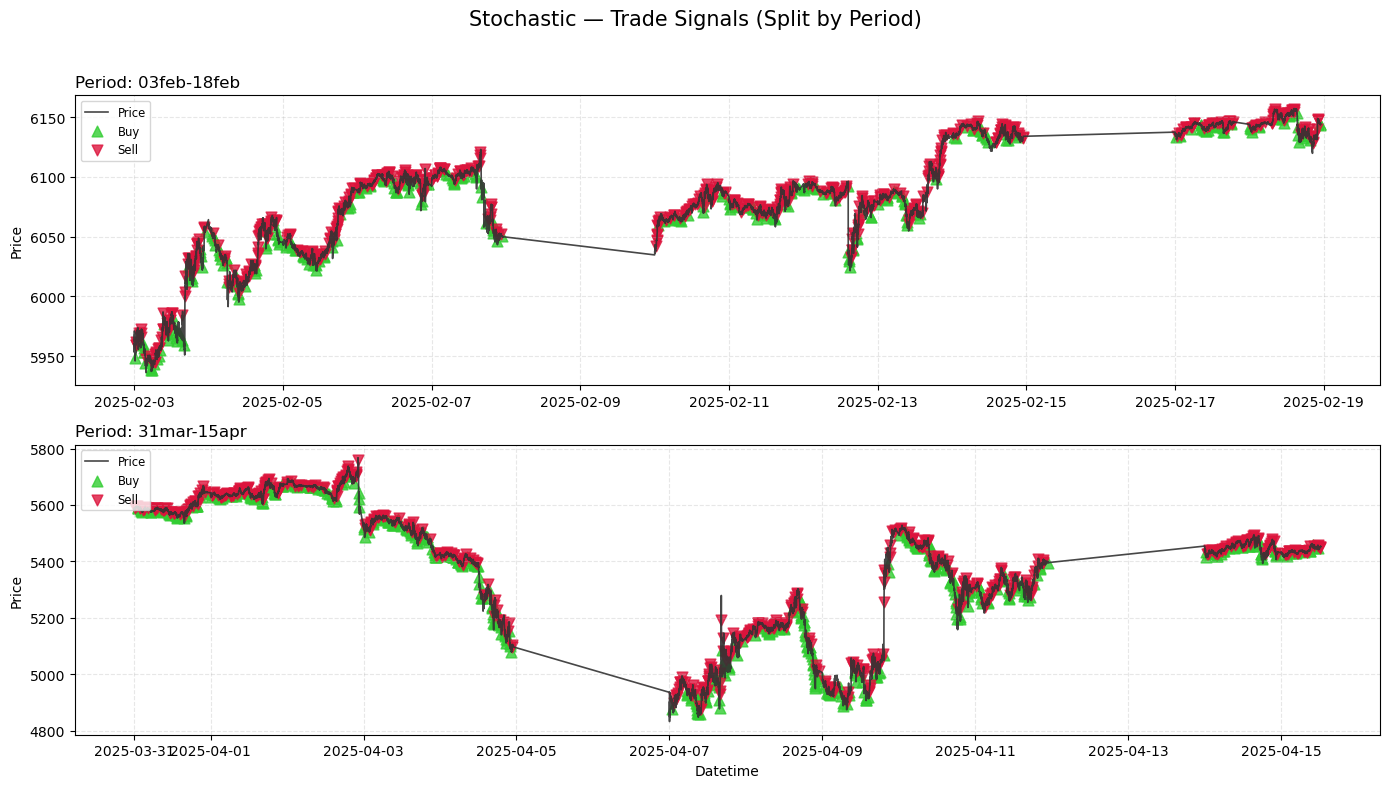

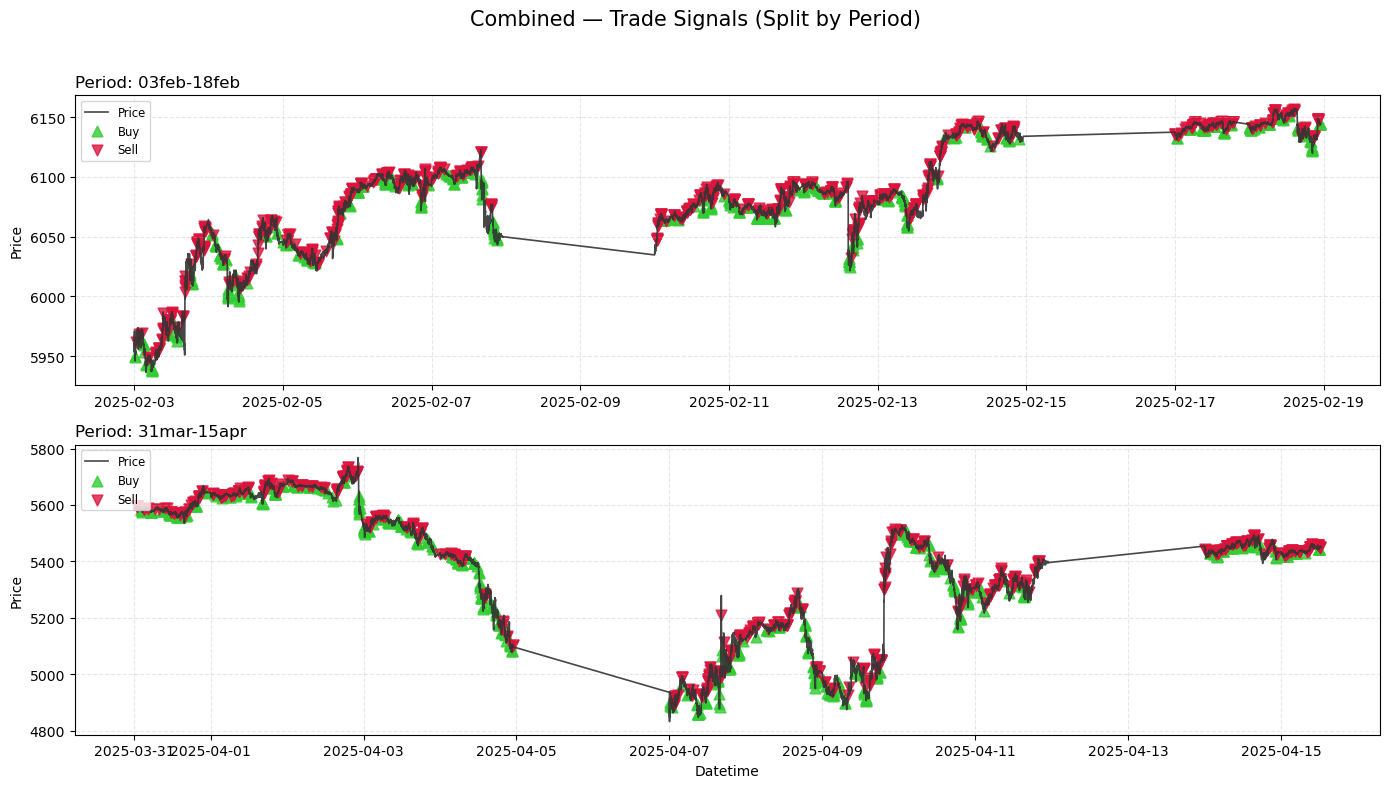

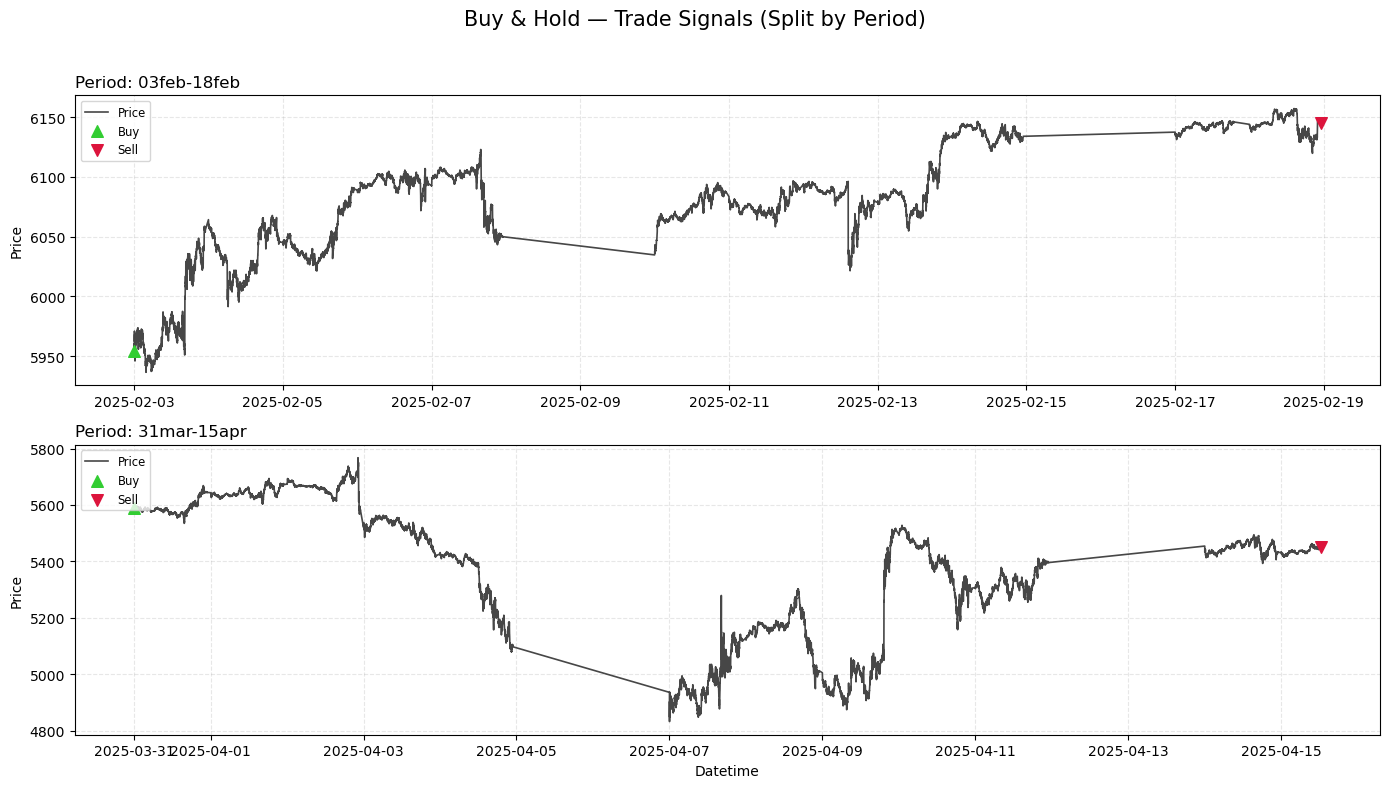

In [15]:
def plot_clean_split(strategy: str):
    """Split view: one subplot per file, cleaner signal visualization."""
    sig_col = _STRATS[strategy]
    if sig_col is None:
        print(f"{strategy} has no signal column.")
        return

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
    fig.suptitle(f"{strategy} — Trade Signals (Split by Period)", fontsize=15)

    for ax, (file_name, path) in zip(axes, _DATA.items()):
        df = add_indicators(parse_intraday(path))
        buy = df[df[sig_col] == 1]
        sell = df[df[sig_col] == -1]

        ax.plot(df.index, df["close"], label="Price", color="#333", linewidth=1.2, alpha=0.9)
        ax.scatter(buy.index, buy["close"], label="Buy", color="limegreen", marker="^", s=60, alpha=0.8)
        ax.scatter(sell.index, sell["close"], label="Sell", color="crimson", marker="v", s=60, alpha=0.8)

        ax.set_title(f"Period: {file_name}", loc='left', fontsize=12)
        ax.set_ylabel("Price")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.legend(loc="upper left", fontsize="small")

    axes[-1].set_xlabel("Datetime")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def plot_buy_and_hold():
    """Plot Buy&Hold strategy showing price curve with Buy at start and Sell at end."""
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
    fig.suptitle("Buy & Hold — Trade Signals (Split by Period)", fontsize=15)

    for ax, (file_name, path) in zip(axes, _DATA.items()):
        df = parse_intraday(path)
        price = df["close"]
        t0, t1 = df.index[0], df.index[-1]
        p0, p1 = price.iloc[0], price.iloc[-1]

        ax.plot(df.index, price, label="Price", color="#333", linewidth=1.2, alpha=0.9)
        ax.scatter(t0, p0, label="Buy", color="limegreen", marker="^", s=70, zorder=5)
        ax.scatter(t1, p1, label="Sell", color="crimson", marker="v", s=70, zorder=5)

        ax.set_title(f"Period: {file_name}", loc='left', fontsize=12)
        ax.set_ylabel("Price")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.legend(loc="upper left", fontsize="small")

    axes[-1].set_xlabel("Datetime")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def plot_all_clean():
    """Run clean visualizations for all strategies including Buy&Hold."""
    for strat in _STRATS:
        if strat != "Buy&Hold":
            plot_clean_split(strat)
    plot_buy_and_hold()


# 👉 Call this to run all charts:
plot_all_clean()


In [16]:
def summarize_signals_and_returns():
    results = []

    for file_name, path in _DATA.items():
        df = add_indicators(parse_intraday(path))

        for strat, sig_col in _STRATS.items():
            df_copy = df.copy()
            initial_cash = 1_000_000

            if strat == "Buy&Hold":
                p0, p1 = df_copy["close"].iloc[0], df_copy["close"].iloc[-1]
                profit = (p1 - p0) * int(initial_cash / p0)
                pct = (profit / initial_cash) * 100
                results.append({
                    "File": file_name,
                    "Strategy": strat,
                    "Buy signals": 1,
                    "Sell signals": 1,
                    "Total trades": 1,
                    "Profit ($)": round(profit, 2),
                    "Profit (%)": round(pct, 2)
                })
            else:
                signals = df_copy[sig_col]
                n_buy = (signals == 1).sum()
                n_sell = (signals == -1).sum()
                port, _ = _backtest(df_copy, sig_col)
                final_value = port[-1]
                profit = final_value - initial_cash
                pct = (profit / initial_cash) * 100

                results.append({
                    "File": file_name,
                    "Strategy": strat,
                    "Buy signals": int(n_buy),
                    "Sell signals": int(n_sell),
                    "Total trades": int(n_buy + n_sell),
                    "Profit ($)": round(profit, 2),
                    "Profit (%)": round(pct, 2)
                })

    df_summary = pd.DataFrame(results)
    df_summary = df_summary[[
        "File", "Strategy", "Buy signals", "Sell signals",
        "Total trades", "Profit ($)", "Profit (%)"
    ]]
    print("\n===== STRATEGY SIGNAL SUMMARY =====")
    print(df_summary.to_string(index=False))
    return df_summary

# 👉 Call this to print the table:
summary_df = summarize_signals_and_returns()



===== STRATEGY SIGNAL SUMMARY =====
       File   Strategy  Buy signals  Sell signals  Total trades  Profit ($)  Profit (%)
03feb-18feb       MACD         8091          8226         16317    -9881.25       -0.99
03feb-18feb        RSI         1601          2117          3718    -2522.00       -0.25
03feb-18feb Stochastic          389           622          1011    -5737.75       -0.57
03feb-18feb   Combined          530           818          1348    -1178.25       -0.12
03feb-18feb   Buy&Hold            1             1             1    31855.25        3.19
31mar-15apr       MACD         7805          8118         15923      863.75        0.09
31mar-15apr        RSI         2061          1910          3971   -14074.25       -1.41
31mar-15apr Stochastic          639           628          1267     9039.50        0.90
31mar-15apr   Combined          651           671          1322     4246.00        0.42
31mar-15apr   Buy&Hold            1             1             1   -24386.00       -

In [17]:
def export_summary_to_latex(df: pd.DataFrame):
    latex_table = df.to_latex(
        index=False,
        float_format="%.2f",
        column_format="llrrrrr",
        caption="Summary of buy/sell signals, trades, and profits per strategy and period.",
        label="tab:strategy-summary",
        longtable=False,
        escape=False
    )
    print("\n===== LaTeX TABLE OUTPUT =====\n")
    print(latex_table)
    return latex_table

# 👉 Run this after summarize_signals_and_returns:
latex_code = export_summary_to_latex(summary_df)



===== LaTeX TABLE OUTPUT =====

\begin{table}
\caption{Summary of buy/sell signals, trades, and profits per strategy and period.}
\label{tab:strategy-summary}
\begin{tabular}{llrrrrr}
\toprule
File & Strategy & Buy signals & Sell signals & Total trades & Profit ($) & Profit (%) \\
\midrule
03feb-18feb & MACD & 8091 & 8226 & 16317 & -9881.25 & -0.99 \\
03feb-18feb & RSI & 1601 & 2117 & 3718 & -2522.00 & -0.25 \\
03feb-18feb & Stochastic & 389 & 622 & 1011 & -5737.75 & -0.57 \\
03feb-18feb & Combined & 530 & 818 & 1348 & -1178.25 & -0.12 \\
03feb-18feb & Buy&Hold & 1 & 1 & 1 & 31855.25 & 3.19 \\
31mar-15apr & MACD & 7805 & 8118 & 15923 & 863.75 & 0.09 \\
31mar-15apr & RSI & 2061 & 1910 & 3971 & -14074.25 & -1.41 \\
31mar-15apr & Stochastic & 639 & 628 & 1267 & 9039.50 & 0.90 \\
31mar-15apr & Combined & 651 & 671 & 1322 & 4246.00 & 0.42 \\
31mar-15apr & Buy&Hold & 1 & 1 & 1 & -24386.00 & -2.44 \\
\bottomrule
\end{tabular}
\end{table}

